In [1]:
import numpy as np
import pandas as pd
from skopt import gp_minimize, gbrt_minimize 
from skopt.plots import plot_convergence, plot_objective
from rl4greencrab.envs.green_crab_monthly_env import greenCrabMonthEnv
from rl4greencrab.envs.green_crab_monthly_env_norm import greenCrabMonthEnvNormalized
from rl4greencrab import evaluate_agent, multiConstAction, simulator
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from huggingface_hub import hf_hub_download
from stable_baselines3 import PPO, TD3
from sb3_contrib import TQC, RecurrentPPO

## Monthly Environment Simulation

In [2]:
def evaluateConstAct(x):
    config = {
        'action_reward_scale': np.array([0.08, 0.08, 0.4]),
        'max_action': 3000,
        # 'env_stoch': 0.,
        'trapm_pmax': 10 * 0.1 * 2.75e-5, #2.26e-6,
        'trapf_pmax': 10 * 0.03 * 2.75e-5, #8.3e-7,
        'traps_pmax': 10 * 2.75e-5, #2.75e-5,

        'loss_a': 0.2,
        'loss_b': 5,
        'loss_c': 5,
        
        'action_reward_exponent': 10,
    }
    env = greenCrabMonthEnv()
    agent = multiConstAction(env=env, action=np.array(x))
    # rewards = simulator(env, agent).simulate()
    # out = np.mean(rewards)
    m_reward = evaluate_agent(agent=agent, ray_remote=True).evaluate(n_eval_episodes=200)
    
    return - m_reward

In [5]:
%%time
max_action = 3000
res = gp_minimize(evaluateConstAct, 3*[(0.0, max_action)], n_calls = 100, verbose=True)
res.x

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.3349
Function value obtained: 17.8419
Current minimum: 17.8419
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.3361
Function value obtained: 26.3175
Current minimum: 17.8419
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.3149
Function value obtained: 16.0457
Current minimum: 16.0457
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.3023
Function value obtained: 31.1941
Current minimum: 16.0457
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.3089
Function value obtained: 46.0191
Current minimum: 16.0457
Iteration No: 6 started. 

[0.0, 0.0, 283.4637219120616]

In [3]:
evaluateConstAct(
    [3000, 0, 0]
)

2025-02-04 08:19:00,708	INFO worker.py:1841 -- Started a local Ray instance.


11.86987415590775

In [6]:
# with nonNormalized env with exponent = 1
evaluateConstAct(
    [0.0, 0.0, 283.4637219120616]
)

5.8582604924255115

In [4]:
# with nonNormalized env with exponent = 10
evaluateConstAct(
    [1159.3031132772392, 1184.1524632666515, 1259.4498917568628]
)

23.1154804623795

In [8]:
import ray
ray.shutdown()

In [5]:
env = greenCrabMonthEnv()
agent = multiConstAction(env=env, action=np.array([1159.3031132772392, 1184.1524632666515, 1259.4498917568628]))
constantData = simulator(env = env, agent = agent).simulate_full_named_obs_acts()
constantDataDF = pd.DataFrame(constantData)
constantDataDF.head()

,t,obs0,act0,act1,act2,rew,rep
0,0,0.0,1159.303113,1184.152463,1259.449892,0.000000,0
1,1,0.0,1159.303113,1184.152463,1259.449892,-0.000143,0
2,2,0.0,1159.303113,1184.152463,1259.449892,-0.000285,0
3,3,0.0,1159.303113,1184.152463,1259.449892,-0.000428,0
4,4,0.0,1159.303113,1184.152463,1259.449892,-0.000570,0


<Axes: xlabel='t'>

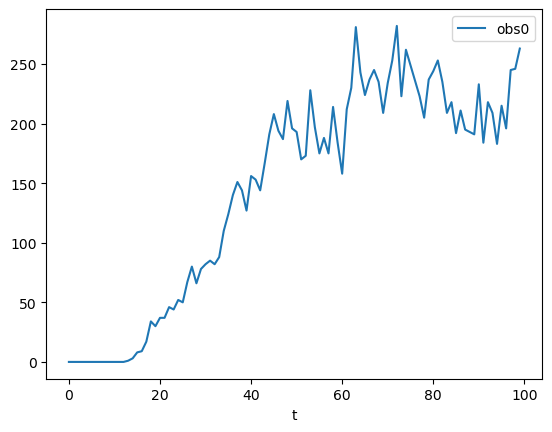

In [6]:
constantDataDF[constantDataDF.rep == 0].plot(x='t', y =['obs0'])

### normalized monthly environment

In [9]:
env = greenCrabMonthEnvNormalized()
agent = multiConstAction(env=env, action=np.array([0.0, 0.0, 283.4637219120616]))

In [10]:
def evaluateConstAct(x):
    env = greenCrabMonthEnvNormalized()
    agent = multiConstAction(env=env, action=np.array(x))
    # rewards = simulator(env, agent).simulate()
    # out = np.mean(rewards)
    m_reward = evaluate_agent(agent=agent, ray_remote=True).evaluate(n_eval_episodes=200)
    
    return - m_reward

In [11]:
# normalized constant action
def normalized_action(act, max_act):
    max_action = max_act
    constant_act = np.array(act)
    return constant_act * 2 / max_action - 1 

In [13]:
max_action = 3000
normalized_action([0.0, 0.0, 283.4637219120616], max_action)

array([-1.        , -1.        , -0.81102419])

In [15]:
constAct_rew = evaluateConstAct([-1.        , -1.        , -0.81102419])
print(f"""
constAct mean rew = {constAct_rew}""")


constAct mean rew = 7.569727491222225


In [16]:
import ray
ray.shutdown()

In [12]:
constantData = simulator(env = env, agent = agent).simulate_full_named_obs_acts()
constantDataDF = pd.DataFrame(constantData)
constantDataDF.head()

,t,obs0,act0,act1,act2,rew,rep
0,0,-1.0,-0.227131,-0.210565,-0.160367,0.000000,0
1,1,-1.0,-0.227131,-0.210565,-0.160367,-0.000143,0
2,2,-1.0,-0.227131,-0.210565,-0.160367,-0.000285,0
3,3,-1.0,-0.227131,-0.210565,-0.160367,-0.000428,0
4,4,-1.0,-0.227131,-0.210565,-0.160367,-0.000570,0


<Axes: xlabel='t'>

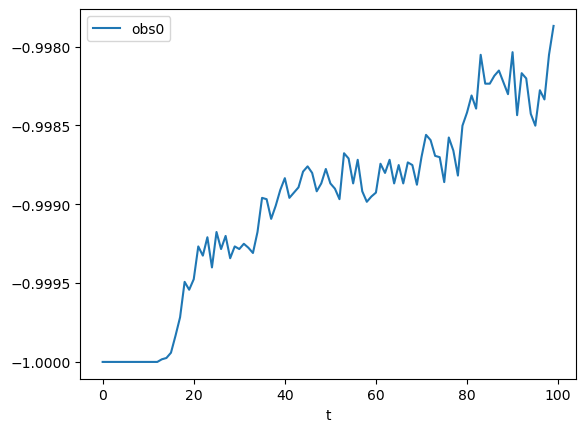

In [13]:
constantDataDF[constantDataDF.rep == 0].plot(x='t', y =['obs0'])

## Loading and evaluating trained reinforcement learning models

In [17]:
repo_id = "jimjiang203/greencrabPPO"
td3_path = hf_hub_download(repo_id=repo_id, filename='td3_gcmonthnorm.zip')
ppo_path = hf_hub_download(repo_id=repo_id, filename='PPO_gcmenorm.zip')
reppo_path = hf_hub_download(repo_id=repo_id, filename='RecurrentPPO_gcmenorm.zip')
tqc_path = hf_hub_download(repo_id=repo_id, filename='TQC_gcmenorm.zip')

In [18]:
evalEnv = greenCrabMonthEnvNormalized()

In [19]:
td3Agent = TD3.load("study_results/tunning_best_gcmonthnorm_TD3", device="cpu")
ppoAgent = PPO.load("PPO_gcmenorm", device="cpu")
tqcAgent = TQC.load("TQC_gcmenorm", device="cpu")
recurrentPPOAgent = RecurrentPPO.load("RecurrentPPO_gcmenorm", device="cpu")

In [20]:
N_EPS = 30

ppo_rew = evaluate_agent(agent=ppoAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)
td3_rew = evaluate_agent(agent=td3Agent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)
tqc_rew = evaluate_agent(agent=tqcAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)
reppo_rew = evaluate_agent(agent=recurrentPPOAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)

2025-02-04 08:26:21,531	INFO worker.py:1841 -- Started a local Ray instance.


In [22]:
import ray
ray.shutdown()

In [21]:
print(f"""
PPO mean rew = {ppo_rew}
TQC mean rew = {tqc_rew}
TD3 mean rew = {td3_rew}
RecurrentPPO mean rew = {reppo_rew}
""")


PPO mean rew = -21.89628060393192
TQC mean rew = -22.66983788140058
TD3 mean rew = -26.660170602022575
RecurrentPPO mean rew = -25.317403441817206



### RecurrentPPO plot

In [19]:
reppoData = simulator(env = evalEnv, agent = recurrentPPOAgent).simulate_full_named_obs_acts()
reppoDataDF = pd.DataFrame(reppoData)
reppoDataDF.iloc[3:10, :]

,t,obs0,act0,act1,act2,rew,rep
3,3,-1.0,-0.061992,-0.403807,-0.045986,-0.001041,0
4,4,-1.0,-0.061992,-0.403807,-0.045986,-0.001387,0
5,5,-1.0,-0.061992,-0.403807,-0.045986,-0.001734,0
6,6,-1.0,-0.061992,-0.403807,-0.045986,-0.002081,0
7,7,-1.0,-0.061992,-0.403807,-0.045986,-0.002428,0
8,8,-1.0,-0.061992,-0.403807,-0.045986,-0.002775,0
9,9,-1.0,-0.061992,-0.403807,-0.045986,-0.003122,0


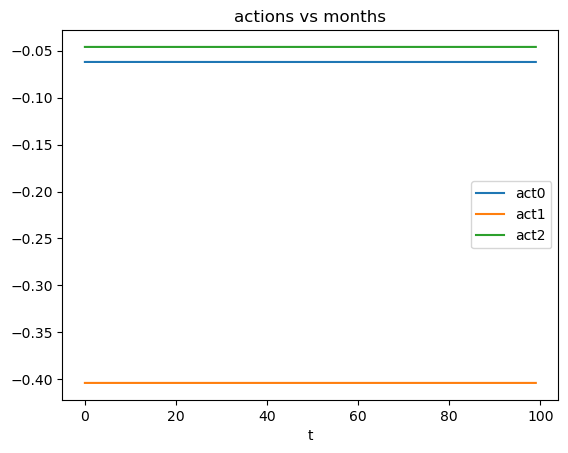

In [20]:
reppoDataDF[reppoDataDF.rep == 0].plot(x='t', y =['act0', 'act1','act2'])
plt.title("actions vs months");

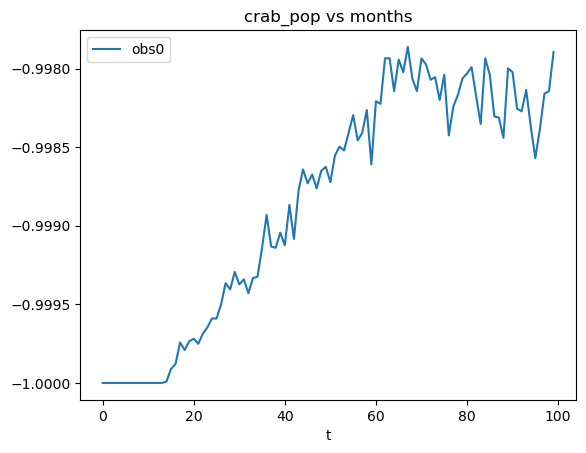

In [21]:
reppoDataDF[reppoDataDF.rep == 0].plot(x='t', y =['obs0'])
plt.title('crab_pop vs months');